### Chapter 16

**CH16 Airbnb random forest and gradient boosting machines**

using the airbnb dataset

version 1.2 2024-01-03

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
from pathlib import Path
import sys
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import plotnine

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

### Get Data

In [2]:
# Current script and repository folder
current_path = os.getcwd()
repository_path = current_path.split('Ch16')[0]

In [3]:
# Add utils folder to sys path 
# Note: os.path.join() creates a string with the right syntax for defining a path for your operating sytem.
sys.path.append(os.path.join(repository_path, 'utils'))

In [4]:
# Define data folder
data_path = os.path.join(repository_path, 'data')

In [5]:
# Import the prewritten helper functions
from py_helper_functions import *

In [6]:
# DATA IMPORT - FROM GITHUB
data = pd.read_csv('https://raw.githubusercontent.com/peterduronelly/DA3-Python-Codes/main/data/airbnb_london_workfile_adj_book.csv')

In [7]:
data.head()

,f_property_type,f_room_type,f_room_type2,f_cancellation_policy,f_bed_type,f_neighbourhood_cleansed,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,...,flag_days_since,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating
0,Apartment,Private room,Private,flexible,Real Bed,Kingston upon Thames,23,1,1.0,100,...,0,0,0,0,4.532599,20.544458,93.119801,8464,778688,4.605170
1,Apartment,Private room,Private,moderate,Couch,Kingston upon Thames,50,2,1.0,91,...,0,0,0,0,6.510258,42.383464,275.927298,450241,302111711,4.510860
2,Apartment,Private room,Private,flexible,Real Bed,Kingston upon Thames,24,2,1.0,80,...,0,0,0,0,5.493061,30.173724,165.746120,58564,14172488,4.382027
3,House,Private room,Private,flexible,Real Bed,Kingston upon Thames,50,2,1.5,94,...,1,1,1,1,5.793014,33.559007,194.407782,106929,34965783,4.543295
4,House,Private room,Private,flexible,Real Bed,Kingston upon Thames,25,1,1.0,94,...,1,1,1,1,5.793014,33.559007,194.407782,106929,34965783,4.543295


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51646 entries, 0 to 51645
Data columns (total 92 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   f_property_type            51646 non-null  object 
 1   f_room_type                51646 non-null  object 
 2   f_room_type2               51646 non-null  object 
 3   f_cancellation_policy      51646 non-null  object 
 4   f_bed_type                 51646 non-null  object 
 5   f_neighbourhood_cleansed   51646 non-null  object 
 6   usd_price_day              51646 non-null  int64  
 7   n_accommodates             51646 non-null  int64  
 8   n_bathrooms                51646 non-null  float64
 9   n_review_scores_rating     51646 non-null  int64  
 10  n_number_of_reviews        51646 non-null  int64  
 11  n_guests_included          51646 non-null  int64  
 12  n_reviews_per_month        51646 non-null  float64
 13  n_extra_people             51646 non-null  int

In [9]:
data.isna().sum().sum()

0

### EDA

In [10]:
# We focus on normal apartments, n<8
data = data[data.n_accommodates < 8]

In [11]:
data.shape

(49826, 92)

In [12]:
# copy a variable - purpose later, see at variable importance
data['n_accommodates_copy'] = data['n_accommodates']

***numerical variables***

In [13]:
# too long to display and read
data.describe().T

,count,mean,std,min,25%,50%,75%,max
usd_price_day,49826.0,8.898404e+01,7.051509e+01,8.000000,4.100000e+01,7.000000e+01,1.100000e+02,9.990000e+02
n_accommodates,49826.0,2.838759e+00,1.494748e+00,1.000000,2.000000e+00,2.000000e+00,4.000000e+00,7.000000e+00
n_bathrooms,49826.0,1.224260e+00,4.664481e-01,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,8.000000e+00
n_review_scores_rating,49826.0,9.245862e+01,8.418474e+00,20.000000,9.200000e+01,9.400000e+01,9.700000e+01,1.000000e+02
n_number_of_reviews,49826.0,1.234014e+01,2.588993e+01,0.000000,0.000000e+00,3.000000e+00,1.200000e+01,3.960000e+02
...,...,...,...,...,...,...,...,...
ln_days_since3,49826.0,1.996072e+02,8.026405e+01,0.000000,1.604325e+02,1.944078e+02,2.411713e+02,4.948179e+02
n_days_since2,49826.0,2.931985e+05,5.640361e+05,0.000000,5.198400e+04,1.069290e+05,2.540160e+05,7.409284e+06
n_days_since3,49826.0,3.046539e+08,9.636140e+08,0.000000,1.185235e+07,3.496578e+07,1.280241e+08,2.016807e+10
ln_review_scores_rating,49826.0,4.520910e+00,1.204214e-01,2.995732,4.521789e+00,4.543295e+00,4.574711e+00,4.605170e+00


In [14]:
data.price.describe(percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).map('{:,.1f}'.format)

count    49,826.0
mean         89.0
std          70.5
min           8.0
1%           20.0
10%          30.0
25%          41.0
50%          70.0
75%         110.0
90%         169.0
99%         350.0
max         999.0
Name: price, dtype: object

***categorical variables***

In [15]:
data.f_room_type.value_counts()

f_room_type
Entire home/apt    24938
Private room       24351
Shared room          537
Name: count, dtype: int64

In [16]:
data.f_property_type.value_counts()

f_property_type
Apartment    37467
House        12359
Name: count, dtype: int64

In [17]:
data.f_number_of_reviews.value_counts()

f_number_of_reviews
2    31575
1    15148
3     3103
Name: count, dtype: int64

In [18]:
data.f_neighbourhood_cleansed.value_counts()

f_neighbourhood_cleansed
Tower Hamlets             5237
Westminster               5025
Hackney                   4393
Camden                    3463
Islington                 3399
Kensington and Chelsea    3247
Southwark                 3144
Lambeth                   3065
Hammersmith and Fulham    2567
Wandsworth                2506
Brent                     1479
Lewisham                  1420
Haringey                  1343
Newham                    1078
Barnet                     890
Ealing                     880
Waltham Forest             842
Greenwich                  836
Richmond upon Thames       754
Merton                     743
Hounslow                   557
Croydon                    504
Bromley                    341
Redbridge                  337
City of London             295
Enfield                    273
Kingston upon Thames       267
Hillingdon                 240
Harrow                     234
Sutton                     139
Barking and Dagenham       133
Bexley        

***split train and test***
- train is where we do it all, incl CV

- first pick a smaller than usual training set so that models run faster and check if works
- if works, start anew without these two lines

In [19]:
data_train, data_holdout = train_test_split( data, train_size=0.7, random_state=42)

In [20]:
data_train.shape, data_holdout.shape

((34878, 93), (14948, 93))

In [21]:
# basic variables inc neighbourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_cancellation_policy",
    "f_bed_type",
    "f_neighbourhood_cleansed",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

# dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "f_room_type:d_familykidfriendly",
    "d_airconditioning:f_property_type",
    "d_cats:f_property_type",
    "d_dogs:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [22]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

### Random forest

For data preparation we are using the [patsy](https://patsy.readthedocs.io/en/latest/overview.html) package (not [this](https://montypython.fandom.com/wiki/Patsy) Patsy, bur almost). `patsy` is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices. It is closely inspired by and compatible with the formula mini-language used in R and S.

In [23]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

`dmatrices()` constructs two design matrices given a formula_like and data. By convention, the first matrix is the “outcome” or “y” data, and the second is the “predictor” or “x” data.

What is X?

In [24]:
type(X)

patsy.design_info.DesignMatrix

In [25]:
X

DesignMatrix with shape (34878, 97)
  Columns:
    ['Intercept',
     'f_property_type[T.House]',
     'f_room_type[T.Private room]',
     'f_room_type[T.Shared room]',
     'f_cancellation_policy[T.moderate]',
     'f_cancellation_policy[T.strict]',
     'f_bed_type[T.Real Bed]',
     'f_neighbourhood_cleansed[T.Barnet]',
     'f_neighbourhood_cleansed[T.Bexley]',
     'f_neighbourhood_cleansed[T.Brent]',
     'f_neighbourhood_cleansed[T.Bromley]',
     'f_neighbourhood_cleansed[T.Camden]',
     'f_neighbourhood_cleansed[T.City of London]',
     'f_neighbourhood_cleansed[T.Croydon]',
     'f_neighbourhood_cleansed[T.Ealing]',
     'f_neighbourhood_cleansed[T.Enfield]',
     'f_neighbourhood_cleansed[T.Greenwich]',
     'f_neighbourhood_cleansed[T.Hackney]',
     'f_neighbourhood_cleansed[T.Hammersmith and Fulham]',
     'f_neighbourhood_cleansed[T.Haringey]',
     'f_neighbourhood_cleansed[T.Harrow]',
     'f_neighbourhood_cleansed[T.Havering]',
     'f_neighbourhood_cleansed[T.Hillin

In [26]:
X.design_info.column_names

['Intercept',
 'f_property_type[T.House]',
 'f_room_type[T.Private room]',
 'f_room_type[T.Shared room]',
 'f_cancellation_policy[T.moderate]',
 'f_cancellation_policy[T.strict]',
 'f_bed_type[T.Real Bed]',
 'f_neighbourhood_cleansed[T.Barnet]',
 'f_neighbourhood_cleansed[T.Bexley]',
 'f_neighbourhood_cleansed[T.Brent]',
 'f_neighbourhood_cleansed[T.Bromley]',
 'f_neighbourhood_cleansed[T.Camden]',
 'f_neighbourhood_cleansed[T.City of London]',
 'f_neighbourhood_cleansed[T.Croydon]',
 'f_neighbourhood_cleansed[T.Ealing]',
 'f_neighbourhood_cleansed[T.Enfield]',
 'f_neighbourhood_cleansed[T.Greenwich]',
 'f_neighbourhood_cleansed[T.Hackney]',
 'f_neighbourhood_cleansed[T.Hammersmith and Fulham]',
 'f_neighbourhood_cleansed[T.Haringey]',
 'f_neighbourhood_cleansed[T.Harrow]',
 'f_neighbourhood_cleansed[T.Havering]',
 'f_neighbourhood_cleansed[T.Hillingdon]',
 'f_neighbourhood_cleansed[T.Hounslow]',
 'f_neighbourhood_cleansed[T.Islington]',
 'f_neighbourhood_cleansed[T.Kensington and Chel

In [27]:
np.asarray(X)

array([[1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 1., ..., 0., 0., 1.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [28]:
import math

In [29]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 9.85.


In [30]:
X.shape

(34878, 97)

In [31]:
type(y)

patsy.design_info.DesignMatrix

In [32]:
# a two-dimensional object
y.shape

(34878, 1)

In [33]:
# using ravel() we flatten it to a one-dimensional data object. 
y.ravel().shape

(34878,)

In [34]:
rfr = RandomForestRegressor(random_state = 20240129)

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

In [35]:
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}

In [36]:
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

`GridsearchCV()` is an exhaustive search over specified parameter values for an estimator.

In [37]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-47.155 total time=   3.3s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-45.679 total time=   2.8s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-46.700 total time=   2.2s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-44.820 total time=   2.2s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-47.830 total time=   2.3s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-47.864 total time=   1.8s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-46.534 total time=   1.7s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-47.494 total time=   1.8s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-45.807 total time=   1.9s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-48.928 total time=   2.0s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-48.510 total time=   1.6s
[CV 2/5] END max_fea

<br>

Cross-validated results are saved in the grid search object's `cv_results_` attribute. Note that *RMSE* is displayed as a negative number. 

In [38]:
rf_model.cv_results_

{'mean_fit_time': array([2.53522692, 1.83750505, 1.52611732, 2.70949063, 2.22060075,
        1.92186985, 3.39151955, 2.71583805, 2.42131767, 3.83383403,
        3.04056129, 2.71932998]),
 'std_fit_time': array([0.42480213, 0.11612058, 0.05170007, 0.14424605, 0.14446145,
        0.02714195, 0.1017421 , 0.14810764, 0.19252177, 0.2064764 ,
        0.16218374, 0.13907185]),
 'mean_score_time': array([0.11804757, 0.09198189, 0.08442397, 0.10649934, 0.08750062,
        0.07819085, 0.1045033 , 0.116506  , 0.08839588, 0.10870304,
        0.0908391 , 0.09738007]),
 'std_score_time': array([2.18570738e-02, 8.38017601e-03, 7.43681711e-03, 1.18053663e-02,
        1.26325268e-02, 9.23804035e-05, 8.68382907e-03, 2.85680581e-02,
        6.82958254e-03, 7.63252817e-03, 1.20280556e-02, 2.34447845e-02]),
 'param_max_features': masked_array(data=[6, 6, 6, 8, 8, 8, 10, 10, 10, 12, 12, 12],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, 

In [39]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

In [40]:
df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

In [41]:
df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-46.436985
1,6,10,-47.325218
2,6,15,-47.927090
3,8,5,-45.504876
4,8,10,-46.327647
5,8,15,-46.896691
6,10,5,-45.060225
7,10,10,-45.789226
8,10,15,-46.254136
9,12,5,-44.678942


In [42]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,46.44,47.33,47.93
8,45.50,46.33,46.90
10,45.06,45.79,46.25
12,44.68,45.36,45.84


In [43]:
rf_model.best_score_

-44.67894217213887

In [44]:
rf_model.best_params_

{'max_features': 12, 'min_samples_leaf': 5}

In [45]:
rf_model.best_estimator_

RandomForestRegressor(max_features=12, min_samples_leaf=5,
                      random_state=20240129)

### Diagnostics

#### feature importances

***individual***

In [46]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 1.39486474e-02, 2.05867135e-01, 5.31367738e-03,
       3.84138021e-03, 1.50181406e-02, 3.82160612e-04, 2.92377335e-04,
       2.05517134e-06, 5.37531747e-04, 6.83463296e-05, 4.74411777e-03,
       1.10683459e-03, 2.57379027e-04, 4.79808816e-04, 2.59190661e-05,
       2.25053380e-04, 1.01290775e-03, 9.44742992e-04, 4.57889785e-04,
       1.96497761e-05, 9.86295927e-07, 5.16916603e-05, 9.71848480e-05,
       1.19984165e-03, 3.35155960e-02, 1.25970881e-05, 7.24779457e-04,
       1.24482748e-03, 4.78668385e-04, 3.27603537e-04, 2.16205813e-04,
       1.04159580e-03, 9.61828205e-04, 7.29696079e-06, 2.97239633e-03,
       8.76110178e-04, 8.21556739e-04, 3.45829100e-02, 1.96442344e-01,
       1.11136474e-01, 1.60404208e-02, 1.01336418e-01, 1.86511582e-02,
       6.12942583e-03, 1.45039758e-02, 5.67147610e-03, 3.87106191e-03,
       9.90446634e-03, 2.45107065e-03, 5.29454249e-03, 7.96836361e-03,
       5.84899948e-03, 2.38106665e-04, 1.39711537e-04, 1.76428547e-03,
      

In [47]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
f_property_type[T.House],0.013949
f_room_type[T.Private room],0.205867
f_room_type[T.Shared room],0.005314
f_cancellation_policy[T.moderate],0.003841
...,...
d_tv,0.025940
d_washer,0.003218
d_washerdryer,0.000531
d_wheelchairaccessible,0.001499


In [48]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

In [49]:
df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,f_room_type[T.Private room],20.6%,20.6%
1,n_accommodates,19.6%,40.2%
2,n_beds,11.1%,51.3%
3,f_bathroom,10.1%,61.5%
4,f_neighbourhood_cleansed[T.Westminster],3.5%,64.9%
5,f_neighbourhood_cleansed[T.Kensington and Chelsea],3.4%,68.3%
6,d_tv,2.6%,70.9%
7,d_familykidfriendly,2.3%,73.2%
8,n_number_of_reviews,1.9%,75.0%
9,d_dryer,1.6%,76.7%


<br> 

Plotting var imp per se results in a nasty chart.

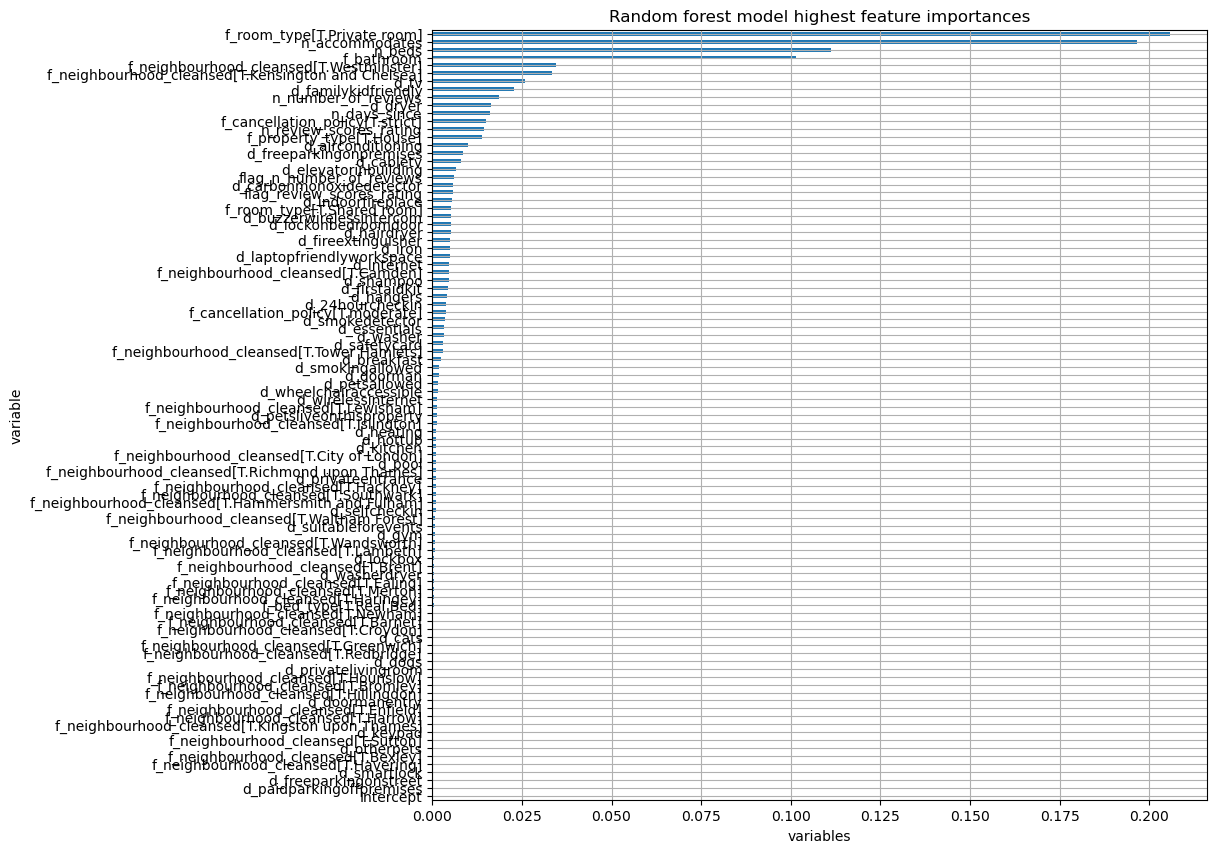

In [50]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [51]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

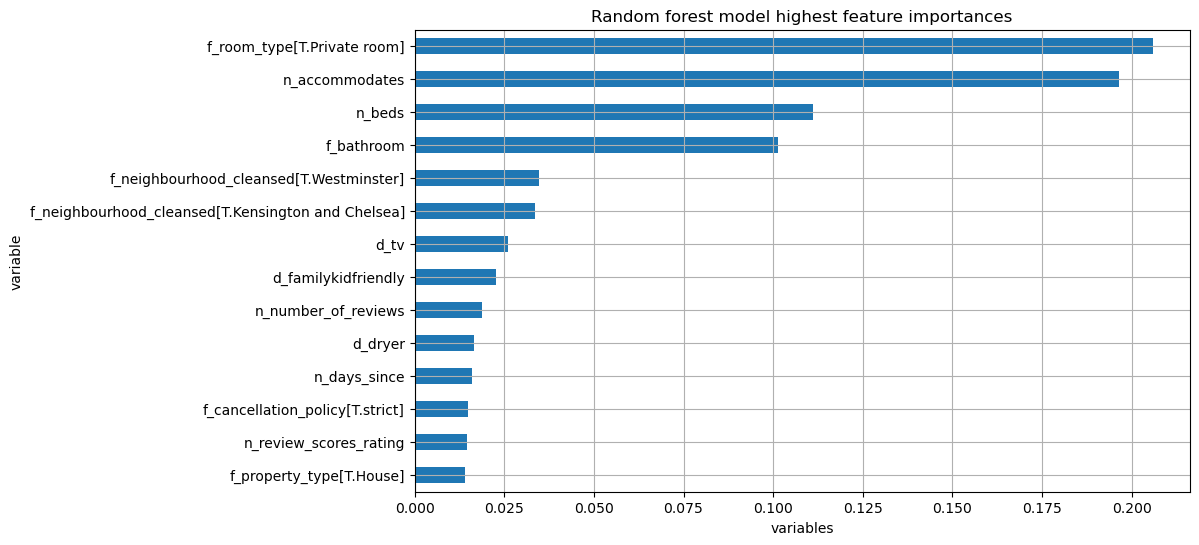

In [52]:
df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

***grouped variable importance - keep binaries created off factors together***

For this, you need to create an `sklearn` Pipeline inclduing `OneHotEncoding` (before, encoding was done by patsy's `dmatrices`). This way permutation_importance can calculate factor variables' importance 

In [53]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

In [54]:
categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [55]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

CPU times: total: 4 s
Wall time: 5.02 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathroom',
                                                   'f_cancellation_policy',
                                                   'f_bed_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_r...
                                                   'd_cats', 'd_dogs',
                                                   'd_doorman',
                                                   'd_doormanentry', 'd_dryer',
                                                   'd_elevatorinbuilding',
                                                   'd_essentials',
                                                   'd_familykidfriendly',
                                                   'd_fireextinguisher',
                                                   'd_firstaidkit',
                                                   'd_freeparkingonpremises',
                                                   'd_freeparkingonstreet',
                                                   'd_gym', 'd_hairdryer',
                                                   'd_hangers', 'd_heating',
                                                   'd_hottub', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_leaf=5,
                                       random_state=20240129))])

Permutation feature importance overcomes limitations of the impurity-based feature importance: they do not have a bias toward high-cardinality features and can be computed on a left-out test set.

In [56]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: total: 2min 18s
Wall time: 2min 48s


In [57]:
result

{'importances_mean': array([ 8.20894741e-02,  3.56557861e-02,  1.86734629e-03,  7.12614491e-03,
         2.58874955e-01,  9.71030844e-02,  1.57147827e-02,  1.40158197e-04,
         6.73178534e-02,  8.13093187e-03,  2.79922533e-03,  3.63925954e-03,
         3.06855271e-03,  1.06986809e-03,  6.71110761e-03,  9.99999872e-05,
         1.23531454e-03,  2.49266388e-03,  1.91217796e-03,  8.54775835e-05,
         2.41034257e-05,  3.36664903e-04,  9.93176873e-06,  8.50048794e-03,
         3.37162747e-03,  1.55493248e-03,  3.41969271e-03,  1.46360646e-03,
         1.79291971e-03,  6.50268972e-03,  8.52621684e-09,  1.88196569e-04,
         2.14200319e-03,  1.38601892e-03,  2.85380089e-04,  3.80043569e-05,
         2.10487903e-03,  1.03380353e-03,  1.52471602e-03, -2.36222675e-06,
         1.29210771e-04,  1.91505304e-03,  1.01766815e-03,  7.21986509e-05,
         3.26409896e-07,  0.00000000e+00,  3.70513547e-04,  1.25764362e-04,
         5.32617207e-04,  1.81642145e-04,  2.88218758e-05,  1.220466

In [58]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

,0
n_accommodates,0.082089
n_beds,0.035656
n_days_since,0.001867
f_property_type,0.007126
f_room_type,0.258875
...,...
d_tv,0.009745
d_washer,0.001295
d_washerdryer,0.000026
d_wheelchairaccessible,0.000257


In [59]:
grouped = [
    "f_bed_type",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "n_days_since",
    "n_accommodates",
    "n_beds",
    "f_neighbourhood_cleansed",
    "f_cancellation_policy",
]

In [60]:
df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

In [61]:
df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,f_room_type,25.9%,25.9%
1,f_bathroom,9.7%,35.6%
2,n_accommodates,8.2%,43.8%
3,f_neighbourhood_cleansed,6.7%,50.5%
4,n_beds,3.6%,54.1%
5,f_cancellation_policy,1.6%,55.7%
6,f_property_type,0.7%,56.4%
7,n_days_since,0.2%,56.6%
8,f_bed_type,0.0%,56.6%


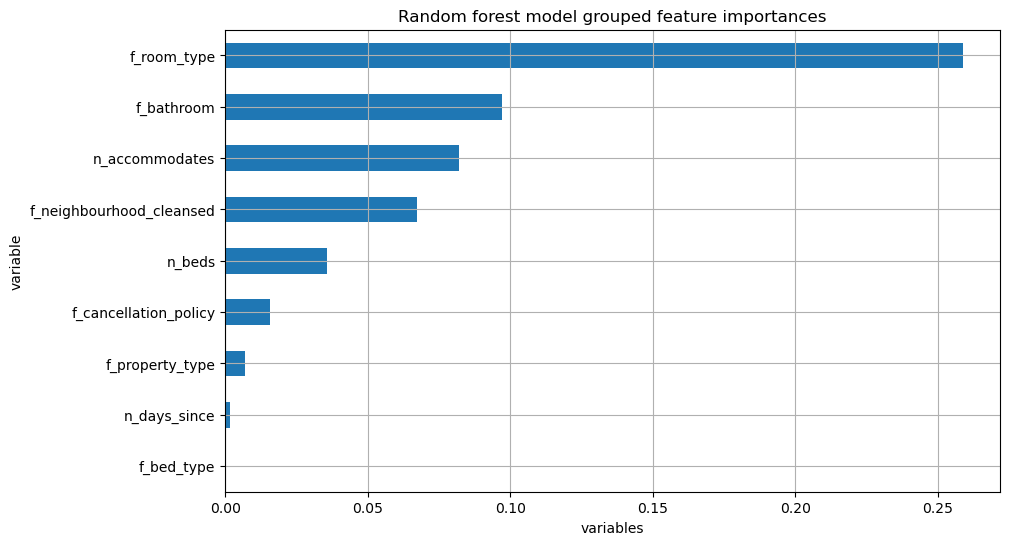

In [62]:
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );

In [63]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,f_room_type,0.258875,0.205867
1,f_bathroom,0.097103,0.402309
2,n_accommodates,0.082089,0.513446
3,f_neighbourhood_cleansed,0.067318,0.614782
4,n_beds,0.035656,0.649365
5,f_cancellation_policy,0.015715,0.682881
6,d_tv,0.009745,0.708820
7,d_dryer,0.008500,0.731517
8,n_number_of_reviews,0.008131,0.750168
9,f_property_type,0.007126,0.766611


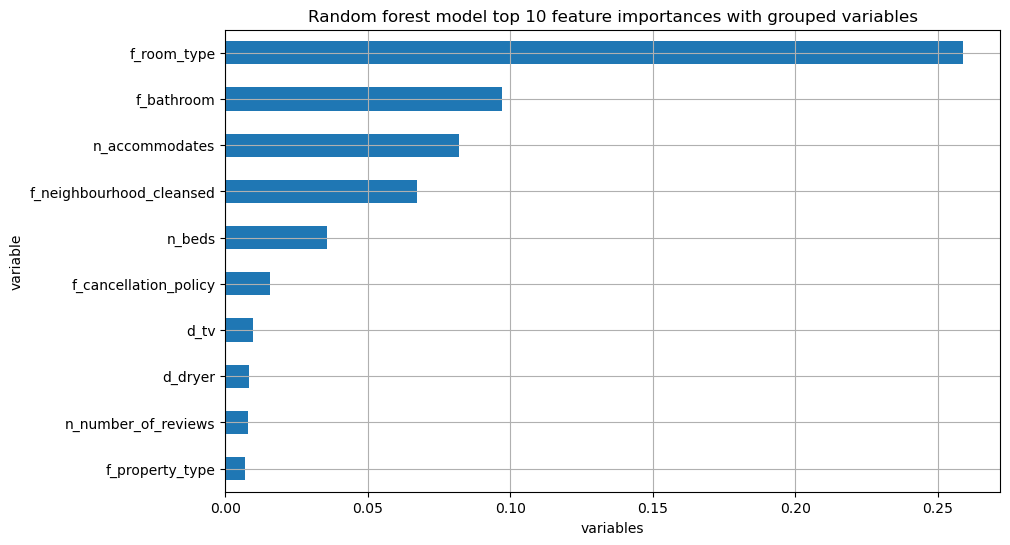

In [64]:
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

### Partial dependence plots 

Note: easy way, sklearn has plot_partial_dependence function we do this on holdout set!   
Also, note that we run it not on the `rf_model` but on the `rf_pipeline` to manage OneHot_Encoding on the fly.

In [65]:
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["n_accommodates"], kind="average"
)

In [66]:
accomodates_pdp

{'grid_values': [array([1, 2, 3, 4, 5, 6, 7], dtype=int64)],
 'values': [array([1, 2, 3, 4, 5, 6, 7], dtype=int64)],
 'average': array([[ 76.26945452,  81.40738784,  85.28039019,  96.0862931 ,
         104.60071723, 108.7921692 , 110.77616627]])}

In [67]:
# We need to access the elements of this complex data structure
type(accomodates_pdp)

sklearn.utils._bunch.Bunch

In [68]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

,number of accomodates,average price
0,1,76.269455
1,2,81.407388
2,3,85.280390
3,4,96.086293
4,5,104.600717
5,6,108.792169
6,7,110.776166


We can do our pdp plots using Pandas built-in plot method.

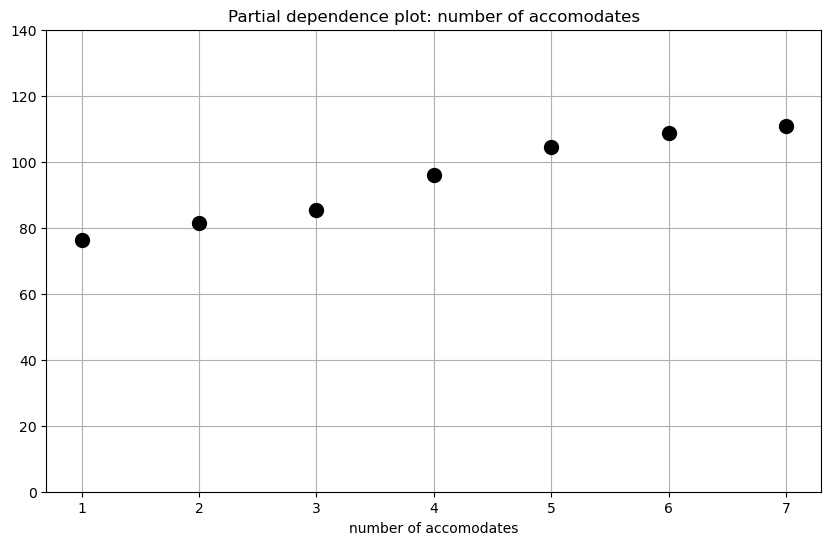

In [69]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 140), 
    title = 'Partial dependence plot: number of accomodates'
);

`sklearn` has its own visualization with complicated syntax. 

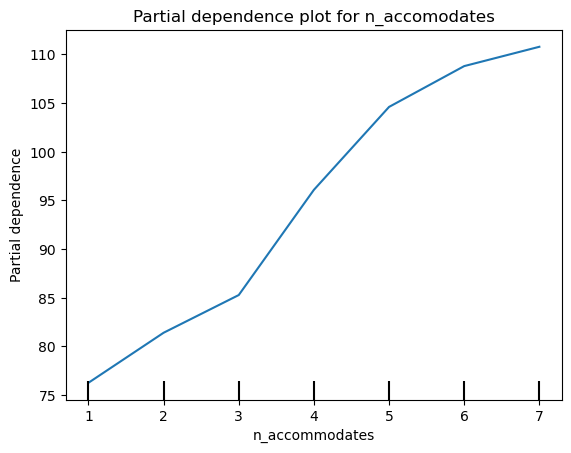

In [70]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(1, 7, num=7)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

In [71]:
roomtype_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["f_room_type"], kind="average"
)

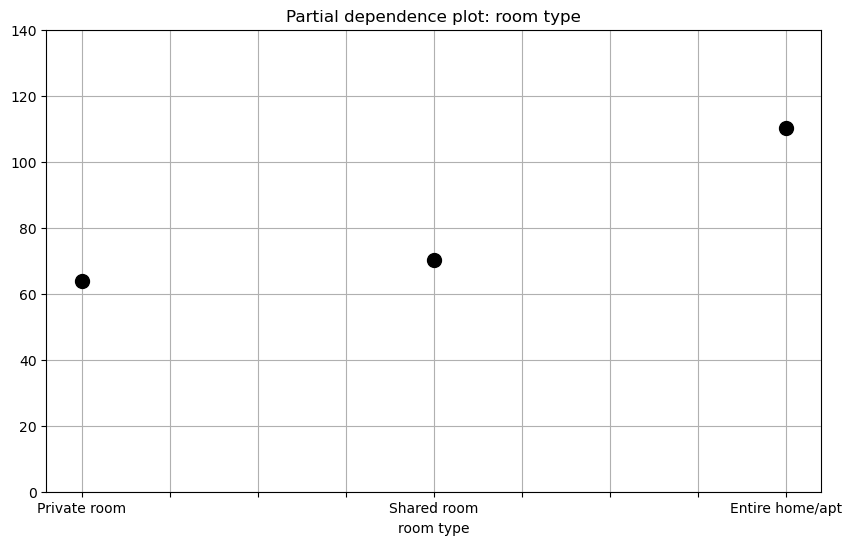

In [72]:
pd.DataFrame(
    {'room type': roomtype_pdp['values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 140), 
    title = 'Partial dependence plot: room type'
);

#### Subsample performance: RMSE / mean(y) 

NOTE:  we do this on the holdout set, using the encoding pipeline `rf_pipeline` again.


In [73]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_pipeline.predict(data_holdout[predictors_2])
)

***Creating tables of heterogeneity by various grouping factors***
- apartman size

This is how we start:

In [74]:
data_holdout_w_prediction['is_low_size'] = data_holdout_w_prediction.n_accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')

In [75]:
data_holdout_w_prediction.iloc[0:5, -5:]

,n_days_since3,ln_review_scores_rating,n_accommodates_copy,predicted_price,is_low_size
46691,1404928,4.521789,3,100.965823,large apt
33332,205379,4.605170,2,89.042902,small apt
30859,26198073,4.290459,2,98.156643,small apt
46018,48627125,4.595120,4,99.004494,large apt
22169,226981,4.605170,2,41.566818,small apt


In [76]:
data_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    61.939318
small apt    30.374166
dtype: float64

Putting it in a function with additional columns

In [77]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )

In [78]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

In [79]:
accom_subset

,rmse,mean_price,rmse_norm
is_low_size,,,
large apt,66.27,144.06,0.46
small apt,31.09,62.86,0.49


- fancy neighborhoods

In [80]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        [
            "Westminster",
            "Camden",
            "Kensington and Chelsea",
            "Tower Hamlets",
            "Hackney",
            "Newham",
        ]
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

neightbourhood_subset

,rmse,mean_price,rmse_norm
f_neighbourhood_cleansed,,,
Camden,55.40,105.01,0.53
Hackney,38.64,76.05,0.51
Kensington and Chelsea,66.61,143.55,0.46
Newham,29.88,61.57,0.49
Tower Hamlets,35.52,74.25,0.48
Westminster,64.88,131.43,0.49


- property type

In [81]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_property_type.isin(["Apartment", "House"])
].groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)

proptype_subset

,rmse,mean_price,rmse_norm
f_property_type,,,
Apartment,43.57,93.19,0.47
House,51.07,77.49,0.66


In [82]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout

,rmse,mean_price,rmse_norm
Total,45.59,89.21,0.51


In [83]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough", "------"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("------")

In [84]:
type_rows

,rmse,mean_price,rmse_norm
Apartment size,------,------,------
Type,------,------,------
Borough,------,------,------
------,------,------,------


**Finally: subsample performance**

In [85]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        type_rows.iloc[[3]],
        all_holdout,
    ]
)

,rmse,mean_price,rmse_norm
Apartment size,------,------,------
large apt,66.27,144.06,0.46
small apt,31.09,62.86,0.49
Type,------,------,------
Apartment,43.57,93.19,0.47
House,51.07,77.49,0.66
Borough,------,------,------
Camden,55.4,105.01,0.53
Hackney,38.64,76.05,0.51
Kensington and Chelsea,66.61,143.55,0.46


### Horserace: compare with other models 

**NOTE: this part of the code is not finished**

1. ***OLS with dummies for area***

 using model B

In [86]:
from sklearn.linear_model import LinearRegression

In [87]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

47.15367981281546

In [88]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

In [89]:
ols_model_coeffs_df

,ols_coefficient
Intercept,-0.000
f_property_type[T.House],7.384
f_room_type[T.Private room],-34.916
f_room_type[T.Shared room],-44.568
f_cancellation_policy[T.moderate],-1.296
...,...
d_tv,6.066
d_washer,-4.694
d_washerdryer,80.073
d_wheelchairaccessible,-1.931


2.  LASSO

using extended model w interactions

In [90]:
from sklearn.linear_model import ElasticNet

The `ElasticNet` model is combines L1 (LASSO) and L2 (Ridge) in a single class. 

The parameter `l1_ratio` (between [0,1]) is the weight of LASSO and Ridge. l1_ratio = 1 is the pure lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [91]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

In [92]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    # {"alpha":[i/100 for i in range(1, 26, 1)]}, > this option takes forever to run
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [93]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

In [94]:
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................alpha=0.05;, score=-46.909 total time=   0.6s
[CV 2/5] END ......................alpha=0.05;, score=-45.683 total time=   0.4s
[CV 3/5] END ......................alpha=0.05;, score=-46.376 total time=   0.5s
[CV 4/5] END ......................alpha=0.05;, score=-44.244 total time=   0.7s
[CV 5/5] END ......................alpha=0.05;, score=-47.264 total time=   0.6s
[CV 1/5] END .......................alpha=0.1;, score=-47.012 total time=   0.4s
[CV 2/5] END .......................alpha=0.1;, score=-45.804 total time=   0.4s
[CV 3/5] END .......................alpha=0.1;, score=-46.422 total time=   0.4s
[CV 4/5] END .......................alpha=0.1;, score=-44.426 total time=   0.4s
[CV 5/5] END .......................alpha=0.1;, score=-47.437 total time=   0.4s
[CV 1/5] END ......................alpha=0.15;, score=-47.123 total time=   0.4s
[CV 2/5] END ......................alpha=0.15;, s

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [95]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
f_property_type[T.House],-0.952
f_room_type[T.Private room],-34.715
f_room_type[T.Shared room],-43.299
f_cancellation_policy[T.moderate],-1.070
f_cancellation_policy[T.strict],4.749
...,...
d_suitableforevents,1.539
d_tv,5.794
d_washer,-4.357
d_washerdryer,26.637


In [96]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.05, l1_ratio=1)

In [97]:
lasso_model_cv.cv_results_

{'mean_fit_time': array([0.67845678, 0.5106071 , 0.48470492, 0.46559601, 0.47682028]),
 'std_fit_time': array([0.09643899, 0.0208278 , 0.01091716, 0.0302957 , 0.03964851]),
 'mean_score_time': array([0.00312448, 0.00625911, 0.00795102, 0.00459127, 0.01125035]),
 'std_score_time': array([0.00624895, 0.00766585, 0.00702989, 0.00591842, 0.00623281]),
 'param_alpha': masked_array(data=[0.05, 0.1, 0.15, 0.2, 0.25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.15},
  {'alpha': 0.2},
  {'alpha': 0.25}],
 'split0_test_score': array([-46.9085158 , -47.01179297, -47.12312143, -47.25358714,
        -47.39355355]),
 'split1_test_score': array([-45.68281619, -45.80359869, -45.92143532, -46.04312036,
        -46.17834193]),
 'split2_test_score': array([-46.3764923 , -46.42170127, -46.48915387, -46.5667388 ,
        -46.67701171]),
 'split3_test_score': array([-44.24400087, -44.

In [98]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

46.095184276815225

3. ***CART model***

In [99]:
from sklearn.tree import DecisionTreeRegressor

In [100]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [101]:
cart_model = DecisionTreeRegressor(random_state=20240129)

Get potential ccp_alpha parameters

In [102]:
path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [103]:
ccp_alphas

array([ 0.00000000e+00, -2.60208521e-17,  6.50521303e-18, ...,
        1.02748000e+02,  6.02687464e+02,  1.48528692e+03])

In [104]:
ccp_alphas.shape

(25795,)

Apply random search to select a "best" alpha, default is 10 iterations
`RandomizedSearchCV` does not calculate all potential alphas, just a random 10-element subset of the many potential alphas

In [105]:
%%time

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha":ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)
cart_model_cv.fit(X,y.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ..ccp_alpha=0.011828987573009616;, score=-62.180 total time=   2.4s
[CV 2/5] END ..ccp_alpha=0.011828987573009616;, score=-63.795 total time=   2.4s
[CV 3/5] END ..ccp_alpha=0.011828987573009616;, score=-63.115 total time=   2.4s
[CV 4/5] END ..ccp_alpha=0.011828987573009616;, score=-59.737 total time=   2.5s
[CV 5/5] END ..ccp_alpha=0.011828987573009616;, score=-63.162 total time=   2.4s
[CV 1/5] END ..ccp_alpha=0.005852099426845686;, score=-62.322 total time=   2.1s
[CV 2/5] END ..ccp_alpha=0.005852099426845686;, score=-63.939 total time=   2.1s
[CV 3/5] END ..ccp_alpha=0.005852099426845686;, score=-63.298 total time=   2.2s
[CV 4/5] END ..ccp_alpha=0.005852099426845686;, score=-59.895 total time=   2.2s
[CV 5/5] END ..ccp_alpha=0.005852099426845686;, score=-63.357 total time=   2.2s
[CV 1/5] END ccp_alpha=1.4335684385572567e-05;, score=-62.471 total time=   0.7s
[CV 2/5] END ccp_alpha=1.4335684385572567e-05;, 

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20240129),
                   param_distributions={'ccp_alpha': array([ 0.00000000e+00, -2.60208521e-17,  6.50521303e-18, ...,
        1.02748000e+02,  6.02687464e+02,  1.48528692e+03])},
                   scoring='neg_root_mean_squared_error', verbose=3)

In [106]:
cart_rmse = pd.DataFrame(cart_model_cv.cv_results_).loc[
    lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha
].mean_test_score.values[0] * -1
cart_rmse

60.45297712201709

4. GBM

**NOTE:** With complex grid search run for a **very long time**

In [107]:
from sklearn.ensemble import GradientBoostingRegressor

In [108]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20, max_features = 10
                                #, n_estimators = 50
                               )

tune_grid = {"n_estimators": [200, 300], "max_depth": [5, 10]}

gbm_model_cv = GridSearchCV(
    gbm,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
    n_jobs=-1
)

In [109]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)

In [110]:
%%time
gbm_pipe.fit(data_train[predictors_2],data_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[Pipeline] ......... (step 2 of 2) Processing regressor, total= 1.5min
CPU times: total: 7.52 s
Wall time: 1min 30s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathroom',
                                                   'f_cancellation_policy',
                                                   'f_bed_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_r...
                                                   'd_freeparkingonpremises',
                                                   'd_freeparkingonstreet',
                                                   'd_gym', 'd_hairdryer',
                                                   'd_hangers', 'd_heating',
                                                   'd_hottub', ...])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=GradientBoostingRegressor(max_features=10,
                                                                  min_samples_split=20),
                              n_jobs=-1,
                              param_grid={'max_depth': [5, 10],
                                          'n_estimators': [200, 300]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [111]:
gbm_model_cv.cv_results_

{'mean_fit_time': array([28.57855468, 42.95249128, 41.76838861, 39.58383627]),
 'std_fit_time': array([0.2475077 , 1.01363344, 4.706214  , 4.86893414]),
 'mean_score_time': array([0.40283489, 0.70681129, 0.34635201, 0.15989318]),
 'std_score_time': array([0.04291538, 0.04143069, 0.1300661 , 0.07681569]),
 'param_max_depth': masked_array(data=[5, 5, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 300, 200, 300],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 5, 'n_estimators': 200},
  {'max_depth': 5, 'n_estimators': 300},
  {'max_depth': 10, 'n_estimators': 200},
  {'max_depth': 10, 'n_estimators': 300}],
 'split0_test_score': array([-44.18923323, -44.37698324, -44.06098226, -44.12388664]),
 'split1_test_score': array([-43.28633737, -43.27630477, -43.44300876, -43.33012313]),
 'split2_test_score': ar

In [112]:
gbm_model_cv.best_estimator_

GradientBoostingRegressor(max_depth=10, max_features=10, min_samples_split=20,
                          n_estimators=200)

In [113]:
gbm_rmse = gbm_model_cv.best_score_*-1

In [114]:
gbm_rmse

43.23406361296296

Comparing model results on CV RMSE.

In [115]:
pd.DataFrame({'model': ['OLS', 'LASSO', 'CART', 'random forest', 'GBM'],
              'CV RMSE': [ols_rmse, lasso_rmse, cart_rmse, all_holdout.rmse[0], gbm_rmse]})

,model,CV RMSE
0,OLS,47.153680
1,LASSO,46.095184
2,CART,60.452977
3,random forest,45.590000
4,GBM,43.234064


***GBM with complex tuning parameter set: takes forever to run***

Histogram-based Gradient Boosting Regression Tree. It is experimental so we need to enable experimental features first. This implementation is inspired by [LightGBM](https://github.com/Microsoft/LightGBM).

In [116]:
# from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [117]:
gbm_broad = HistGradientBoostingRegressor(random_state = 20240129)

In [118]:
tune_grid = {
    "max_iter": [50, 100, 200],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.1, 0.15, 0.2],
    "min_samples_leaf": [5, 10, 20, 30],
}

gbm_model_cv_broad = GridSearchCV(
    gbm_broad,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
)

In [119]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe_broad = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv_broad)], verbose=True
)

In [120]:
%%time
gbm_pipe_broad.fit(data_train[predictors_2],data_train.price)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total=   0.1s
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5; 1/108] START learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5
[CV 1/5; 1/108] END learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5;, score=-51.114 total time=   0.2s
[CV 2/5; 1/108] START learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5
[CV 2/5; 1/108] END learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5;, score=-49.594 total time=   0.1s
[CV 3/5; 1/108] START learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5
[CV 3/5; 1/108] END learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5;, score=-50.482 total time=   0.1s
[CV 4/5; 1/108] START learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5
[CV 4/5; 1/108] END learning_rate=0.1, max_depth=1, max_iter=50, min_samples_leaf=5;, score=-49.126 total time=   0.1s
[CV 5/5; 1/108] START learning_rate=0.1, max_d

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathroom',
                                                   'f_cancellation_policy',
                                                   'f_bed_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_r...
                                                   'd_freeparkingonstreet',
                                                   'd_gym', 'd_hairdryer',
                                                   'd_hangers', 'd_heating',
                                                   'd_hottub', ...])])),
                ('regressor',
                 GridSearchCV(cv=5,
                              estimator=HistGradientBoostingRegressor(random_state=20240129),
                              param_grid={'learning_rate': [0.1, 0.15, 0.2],
                                          'max_depth': [1, 5, 10],
                                          'max_iter': [50, 100, 200],
                                          'min_samples_leaf': [5, 10, 20, 30]},
                              scoring='neg_root_mean_squared_error',
                              verbose=10))],
         verbose=True)

In [121]:
gbm_model_cv_broad.best_params_

{'learning_rate': 0.15,
 'max_depth': 10,
 'max_iter': 100,
 'min_samples_leaf': 30}

In [122]:
print('Broad GBM RMSE is: {:.4f}.'.format(gbm_model_cv_broad.best_score_*-1))
print('Simple GBM RMSE is: {:.4f}.'.format(gbm_model_cv.best_score_*-1))

Broad GBM RMSE is: 43.2800.
Simple GBM RMSE is: 43.2341.
